In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

filepath = '/content/drive/MyDrive/Data/data.json'

with open(filepath, "r") as fp:
    data = json.load(fp)

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.

    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

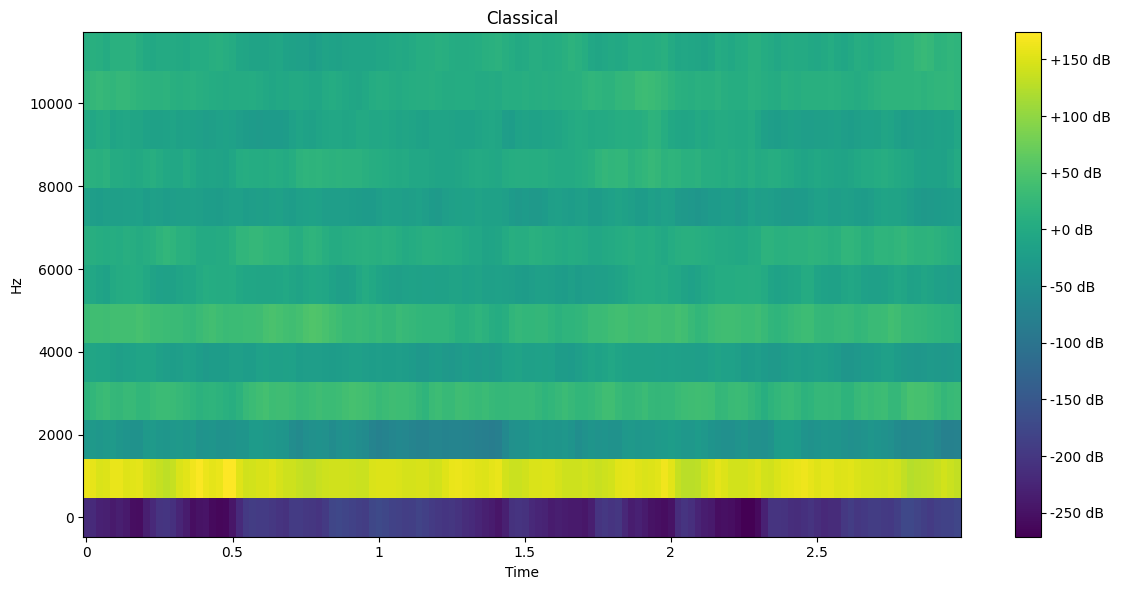

In [ ]:
# Plot MFCC example to ensure data was imported properly
idx = 1000
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

In [ ]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [ ]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4894, 132, 13), y training data shape: (4894,)
X validation data shape: (2098, 132, 13), y validation data shape: (2098,)


In [ ]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs

    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)

    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.show()

In [ ]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))

(4894, 132, 13, 1)

In [ ]:
 
 
model_cnn3 = Sequential()

 
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))
 
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [ ]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
 
datagen = ImageDataGenerator(vertical_flip=True)

In [ ]:
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1
 
)

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - acc: 0.1609 - loss: 3.6117 - val_acc: 0.3203 - val_loss: 1.9428
Epoch 2/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - acc: 0.2835 - loss: 2.4048 - val_acc: 0.3699 - val_loss: 1.9771
Epoch 3/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.3324 - loss: 2.0335 - val_acc: 0.3866 - val_loss: 1.9070
Epoch 4/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.3652 - loss: 1.8479 - val_acc: 0.3823 - val_loss: 1.9537
Epoch 5/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3757 - loss: 1.7812 - val_acc: 0.4056 - val_loss: 1.9623
Epoch 6/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4302 - loss: 1.6269 - val_acc: 0.4075 - val_loss: 2.0208
Epoch 7/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4422 - loss: 1.5758 - val_acc: 0.4385 - val_loss: 1.9510
Epoch 8/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4555 - loss: 1.5308 - val_acc: 0.4433 - val_loss: 1.9593
Epoch 9/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

In [ ]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8386 - loss: 0.7463
Test Loss: 0.7471837997436523
Test Accuracy: 0.8371704816818237


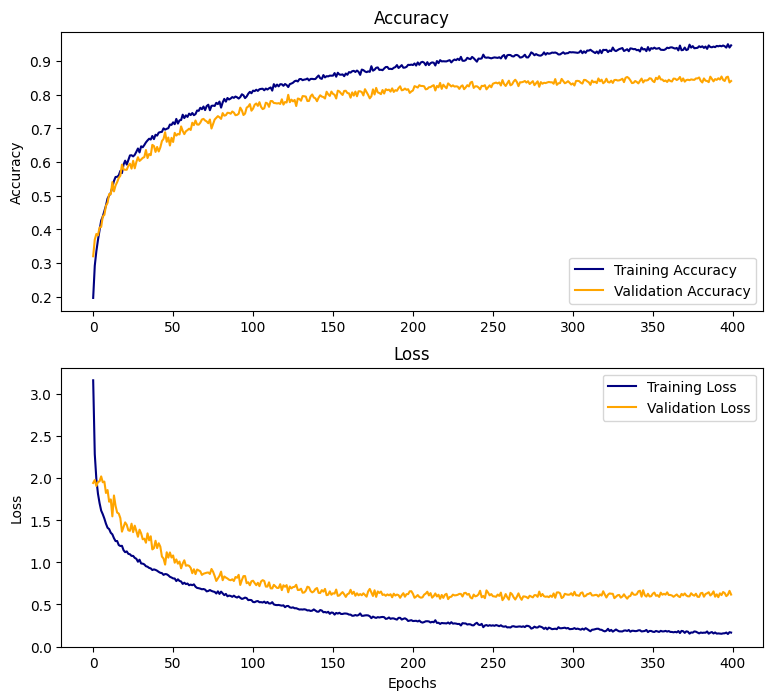

In [ ]:
plot_history(hist_cnn3)

In [ ]:
# حفظ النموذج كملف .h5
model_cnn3.save("model_cnn3.h5")

# تنزيل النموذج إلى الجهاز المحلي
from google.colab import files
files.download("model_cnn3.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_cnn3.save('/content/drive/My Drive/model_cnn4.h5')
print("Model saved to Google Drive!")

Model saved to Google Drive!


In [ ]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.

    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.

    Returns:
        preds_num (list): List of genre predictions (number format, 0-9)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

In [ ]:
preds_num, preds_name = make_prediction(model_cnn3, X_test_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

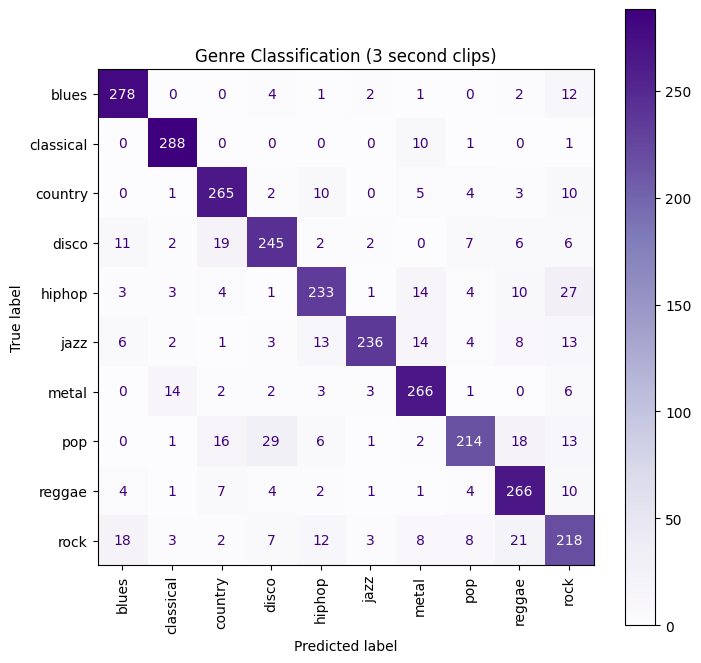

In [ ]:
# Plot confusion matrix for review
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');